# NCD ANALYSIS

1. Recreate cascades in the Monthly PPT
2. Identify patterns from the data
3. Track progress vs targets

## Targets
1. Annual (Combined)- 117525      Chitungwiza-39410 Bulawayo-78115
2. Gen Pop - 64800                Chitungwiza-21960 Bulawayo-43200
3. PLHIV - 52365                  Chitungwiza-17450 Bulawayo-34915

### Plan
1. Function that produces cascades by province and by population

#### N.B. CURRENTLY MISSING LINKAGE TO SERVICES DATA


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from tabulate import tabulate
%matplotlib inline

<h3 style="color: red"> All Functions</h3>

In [2]:
def screened_period(dataframe, last_date, first_date="2022-12-01"):
    """This function calculates the total screened between 2 time periods. the first day is a kwarg in the
    from of a string with format YYYY-MM-DD that can be changed by the user depending on the date they want 
    to first search.last_date should be a string object in the form YYYY-MM-DD"""
    
    mask = (dataframe["Enrollment date"]> first_date) & (dataframe["Enrollment date"] <= last_date)
    dataframe = dataframe.loc[mask]
    return dataframe, len(dataframe)

In [3]:
# Number with NCDs in the current Month

def ncd_pos(dataframe):
    """returns dataframes for diabetics, hypertensives and total referred regardless of condition"""
    diabetic = dataframe[dataframe['CTL - NCD Random blood sugar'] > 11]
    hypertensive = dataframe[(dataframe['CTL - NCD Systolic blood pressure']>140)|(dataframe['CTL - NCD Diastolic blood pressure']>90)]
    referred = dataframe[dataframe['CTL - NCD If Hypertensive (i.e. >140/90mmHg) or diabetic (11mmol/L) client has been referred for treatment and care at the health facility']==1.0]
    return diabetic, hypertensive, referred
    

In [4]:
def annotate(rect, ax):
    """annotates bar graph"""
    for item in range(len(rect)):
        height = rect[item]
        ax.annotate('{}'.format(height), fontsize=10, xy = (item, height), xytext = (10,2),
                   textcoords = 'offset points', ha = 'right', va = 'bottom')

In [5]:
def art_genpop(dataframe):
    """this function returns dataframes by ART and Gen. Population"""
    on_art = dataframe[dataframe['CTL - Is client on ART']==1.0]
    gen_pop = dataframe[dataframe['CTL - Is client on ART']==0.0]
    return on_art, gen_pop

In [6]:
def male_female(dataframe):
    """this function returns dataframes by gender"""
    male = dataframe[dataframe['CTL - Client Sex']=="Male"]
    female = dataframe[dataframe['CTL - Client Sex']=="Female"]
    return male, female

In [7]:
def get_facility(org_unit_name):
    """This function returns the facility name from the column Organisation unit name. Not for general use"""
    try:
        return org_unit_name.split('-')[1]
    except:
        return org_unit_name   

In [8]:
def monthly_cascade(target, last_month_screened, ncds_total, referrals, percent_screen, percent_ncd, percent_refer):
    """returns a bar graph of the overall cascade: Target for screening, Screened, NCDs (Hypertension + DM), Refered
    missing --> linked. This can be added when source obtained from COACs"""
    
    fig, ax = plt.subplots(figsize=(15,7))
    height = [target, last_month_screened, ncds_total, referrals]

    ax.bar(x = ["Monthly Target", "Screened", "Hptnsv/Prediabetic", "Referred"], height=height, color=["#C55A11","#F8CBAD","#F8CBAD","#F8CBAD"])
    annotate(height, ax)
    
    # remember to change the starting point of the arrows as the cascades improve
    ax.annotate(f"{percent_screen}%",
                xy=(0.8, last_month_screened*1.01), xycoords='data',
                xytext=(0.5, target*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    ax.annotate(f"{percent_ncd}%",
                xy=(1.8, ncds_total*1.01), xycoords='data',
                xytext=(1.5, last_month_screened*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"),
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    ax.annotate(f"{percent_refer}%",
                xy=(2.8, referrals*1.01), xycoords='data',
                xytext=(2.5, ncds_total), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"),
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')

    plt.show()

In [9]:
def cascade_indicators_monthly(dataframe, target):
    """returns the indicators that will provide input into the monthly cascasde graph"""    
    
    last_month, screened_last_month = screened_period(dataframe, "2023-03-31", first_date="2023-03-01")
    diabetic, hypertensive, referred = ncd_pos(last_month)
    ncd = len(diabetic)+len(hypertensive)
    refer = len(referred)

    # percentages
    perc_screened = round((screened_last_month/target*100),1)
    perc_ncd = round((ncd/screened_last_month*100),1)
    perc_refered = round((refer/ncd*100),1)   
    
    return len(last_month), ncd, refer, perc_screened, perc_ncd, perc_refered

In [10]:
def monthly_target(province, dataframe, date_last_month, months_implemented):
    '''Setting the tone for the monthly target. 
    Province --> insert either National, Bulawayo or Chitungwiza,
    date_last_month --> last date of the previous month in format YYYY-MM-DD,
    months_implemented --> number of program months completed beginning December 2022'''
    
    if province == "National":
        annual_target = 117525
    elif province == "Bulawayo":
        annual_target = 78115
    elif province == "Chitungwiza":
        annual_target = 39410   
    
    last_month, cumulative = screened_period(dataframe, date_last_month)
    months_implemented = months_implemented    # Beginning December 2022
    remaining_months = 12-months_implemented

    monthly_target = round((annual_target-cumulative)/remaining_months, 0)
    return monthly_target

In [11]:
def referrals_per_ncd(dataframe):
    """returns a dataframe with referrals by NCD. Used with NCD specific dataframe"""
    result = dataframe[dataframe['CTL - NCD If Hypertensive (i.e. >140/90mmHg) or diabetic (11mmol/L) client has been referred for treatment and care at the health facility']==1.0]
    return result

In [12]:
def ncd_grid(hptn_art, dm_art, hptn_gen, dm_gen):
    """returns a 4 image grid comparing NCD by population. ie. gen pop vs. PLHIV. 
    Inputs into this grid are lists with 3 values: screened, hypertensive, referrals"""
    height_hptn_art = hptn_art
    height_dm_art = dm_art
    height_hptn_gen = hptn_gen
    height_dm_gen = dm_gen
    
    colors = ["#008080", "#90EE90", "#90EE90"]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(16,12))
    ax1.bar(x = ["Screened_ON_ART", "Hypertensive", "Refered"], height=height_hptn_art, color=colors)
    ax2.bar(x = ["Screened_ON_ART", "Diabetic", "Refered"], height=height_dm_art, color=colors)
    ax3.bar(x = ["Screened_GEN_POP", "Hypertensive", "Refered"], height=height_hptn_gen, color=colors)
    ax4.bar(x = ["Screened_GEN_POP", "Diabetic", "Refered"], height=height_dm_gen, color=colors)
    
    annotate(height_hptn_art, ax1)
    annotate(height_dm_art, ax2)
    annotate(height_hptn_gen, ax3)
    annotate(height_dm_gen, ax4)
    
    # first axis   
    ax1.annotate("{:.1f}%".format((height_hptn_art[1]/height_hptn_art[0]*100)),
                xy=(0.8, height_hptn_art[1]*1.01), xycoords='data',
                xytext=(0.5, height_hptn_art[0]*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    ax1.annotate("{:.1f}%".format((height_hptn_art[2]/height_hptn_art[1]*100)),
                xy=(1.8, height_hptn_art[2]*1.01), xycoords='data',
                xytext=(1.5, height_hptn_art[1]*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    
    # second axis
    ax2.annotate("{:.1f}%".format((height_dm_art[1]/height_dm_art[0]*100)),
                xy=(0.8, height_dm_art[1]*1.01), xycoords='data',
                xytext=(0.5, height_dm_art[0]*1/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    ax2.annotate("{:.1f}%".format((height_dm_art[2]/height_dm_art[1]*100)),
                xy=(1.8, height_dm_art[2]*1.01), xycoords='data',
                xytext=(1.5, height_dm_art[1]*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    
    # third axis
    ax3.annotate("{:.1f}%".format((height_hptn_gen[1]/height_hptn_gen[0]*100)),
                xy=(0.8, height_hptn_gen[1]*1.01), xycoords='data',
                xytext=(0.5, height_hptn_gen[0]*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    ax3.annotate("{:.1f}%".format((height_hptn_gen[2]/height_hptn_gen[1]*100)),
                xy=(1.8, height_hptn_gen[2]*1.01), xycoords='data',
                xytext=(1.5, height_hptn_gen[1]*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    
    # fourth axis
    ax4.annotate("{:.1f}%".format((height_dm_gen[1]/height_dm_gen[0]*100)),
                xy=(0.8, height_dm_gen[1]*1.01), xycoords='data',
                xytext=(0.5, height_dm_gen[0]*1/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    ax4.annotate("{:.1f}%".format((height_dm_gen[2]/height_dm_gen[1]*100)),
                xy=(1.8, height_dm_gen[2]*1.01), xycoords='data',
                xytext=(1.5, height_dm_gen[1]*3/4), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="angle, angleA=90, angleB=-180, rad=10"), 
                size=14, color='red', fontweight='bold', backgroundcolor='yellow')
    
    
    plt.show()

<h3 style="color: red">DataFrame - Munging</h3>

In [13]:
df = pd.read_csv("enrollments.csv")
df["Enrollment date"] = pd.to_datetime(df["Enrollment date"])
df["Facility"] = df["Organisation unit name"].apply(lambda x: get_facility(x))

In [14]:
# insert provincial names into Dataframe -->

district = {}
for i in df['Facility']:
    if "Seke" in i or "Mary" in i or "Zengeza" in i or "COA" in i:
        district[i] = "Chitungwiza"
    else:
        district[i] = "Bulawayo"

df["Province"] = df['Facility'].apply(lambda x: district[x])

In [15]:
# Removing test date from the dataframe --

#Indexes for Test dataframe
test_zw_index = df[df['Organisation unit name'] == '_Test ZW'].index
hsqo_test_zw_index = df[df['Organisation unit name'] == 'HSQO_test'].index

# Drop Test data from the dataframe
try:
    for i in test_zw_index:
        df = df.drop(i)
    for i in hsqo_test_zw_index:
        df = df.drop(i)
except:
    pass

In [16]:
# Obtaining Client Ages
df['CTL - Client Date of Birth'] = pd.to_datetime(df['CTL - Client Date of Birth'])
df["Age"] = df['CTL - Client Date of Birth'].apply(lambda x: ((datetime.datetime.today() - x).total_seconds() / (365.25 * 24 * 3600)))

### Essential Variables 
To keep code DRY

In [17]:
last_date_prev_month = '2023-02-28'   # for calculation of cumulative reporting month target
first_date_reporting_month = '2023-03-01' # reporting month
last_date_reporting_month = '2023-03-31'

<h3 style="color: red">Analyses</h3>

In [18]:
# age of clients screened overall
df.Age.describe()

count    8557.000000
mean       49.612268
std        14.461737
min         0.030023
25%        42.850009
50%        49.168969
75%        57.327764
max       122.606340
Name: Age, dtype: float64

In [19]:
# age of clients screened in reporting period
screened_period(df, last_date_reporting_month, first_date=first_date_reporting_month)[0].Age.describe()

count    3640.000000
mean       48.896063
std        14.197700
min         0.030023
25%        42.776087
50%        48.926669
75%        56.853431
max        99.821946
Name: Age, dtype: float64

In [20]:
target_national = monthly_target("National", df, last_date_prev_month, 3)
last_month_nat, ncd_nat, referred_nat, perc_screened_nat, perc_ncd_nat, perc_refered_nat = cascade_indicators_monthly(df, target_national)

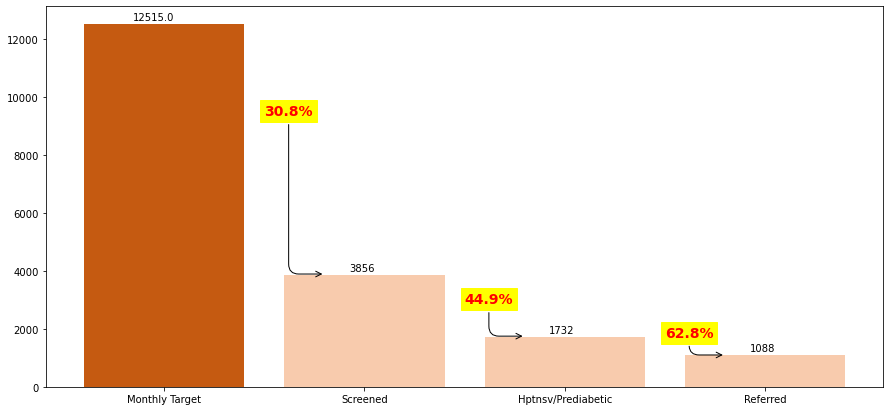

In [21]:
monthly_cascade(target_national, last_month_nat, ncd_nat, referred_nat, perc_screened_nat, perc_ncd_nat, perc_refered_nat)

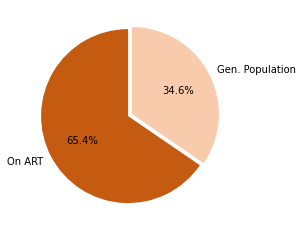

In [22]:
on_art_nat, gen_pop_nat = art_genpop(df)
fig, ax = plt.subplots()
ax.pie(x = [len(on_art_nat), len(gen_pop_nat)], labels=["On ART", "Gen. Population"], 
       startangle=90, explode=[0.025, 0.025], colors=["#C55A11","#F8CBAD"], autopct='%1.1f%%')
plt.show()

### PROVINCIAL

In [23]:
# creating dataframes for the individual provinces here:

provinces = df.groupby("Province")
bulawayo = provinces.get_group("Bulawayo")
chitungwiza = provinces.get_group("Chitungwiza")

In [24]:
# creating dataframes for gen pop and plhiv by province here: 

byo_gen, byo_art = art_genpop(bulawayo)
chit_gen, chit_art = art_genpop(chitungwiza)

## Bulawayo

In [25]:
# Monthly Targets
target_byo = monthly_target("Bulawayo", df, last_date_prev_month, 3)
last_month_byo, ncd_byo, referred_byo, perc_screened_byo, perc_ncd_byo, perc_refered_byo = cascade_indicators_monthly(bulawayo, target_byo)

### Bulawayo Overall Cascade

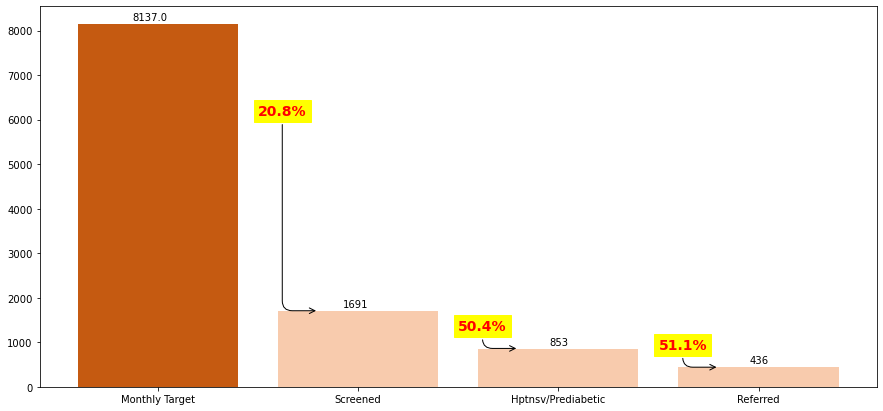

In [26]:
monthly_cascade(target_byo, last_month_byo, ncd_byo, referred_byo, perc_screened_byo, perc_ncd_byo, perc_refered_byo)

### Distibution Gen Pop: On ART (Bulawayo)

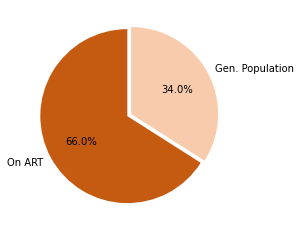

In [27]:
on_art_byo, gen_pop_byo = art_genpop(bulawayo)
fig, ax = plt.subplots()
ax.pie(x = [len(on_art_byo), len(gen_pop_byo)], labels=["On ART", "Gen. Population"], 
       startangle=90, explode=[0.025, 0.025], colors=["#C55A11","#F8CBAD"], autopct='%1.1f%%')
plt.show()

In [28]:
# -->> plhiv-hypertension, plhiv - diabetes, gen_pop-hypertension, gen-pop-diabetes <<--#

### PLHIV vs GEN. POP Cascades - Bulawayo

In [29]:
on_art_byo_df, on_art_byo_screened = screened_period(on_art_byo, last_date_reporting_month, first_date=first_date_reporting_month)
on_art_byo_dm, on_art_byo_hptn, on_art_byo_referred = ncd_pos(on_art_byo_df)

gen_pop_byo_df, gen_pop_byo_screened = screened_period(gen_pop_byo, last_date_reporting_month, first_date=first_date_reporting_month)
gen_pop_byo_dm, gen_pop_byo_hptn, gen_pop_byo_referred = ncd_pos(gen_pop_byo_df)

In [30]:
# inputs into ncd_grid:

byo_hptn_cascade_art = [on_art_byo_screened, len(on_art_byo_hptn), len(referrals_per_ncd(on_art_byo_hptn))]
byo_dm_cascade_art = [on_art_byo_screened, len(on_art_byo_dm), len(referrals_per_ncd(on_art_byo_dm))]

byo_hptn_cascade_gen = [gen_pop_byo_screened, len(gen_pop_byo_hptn), len(referrals_per_ncd(gen_pop_byo_hptn))]
byo_dm_cascade_gen = [gen_pop_byo_screened, len(gen_pop_byo_dm), len(referrals_per_ncd(gen_pop_byo_dm))]

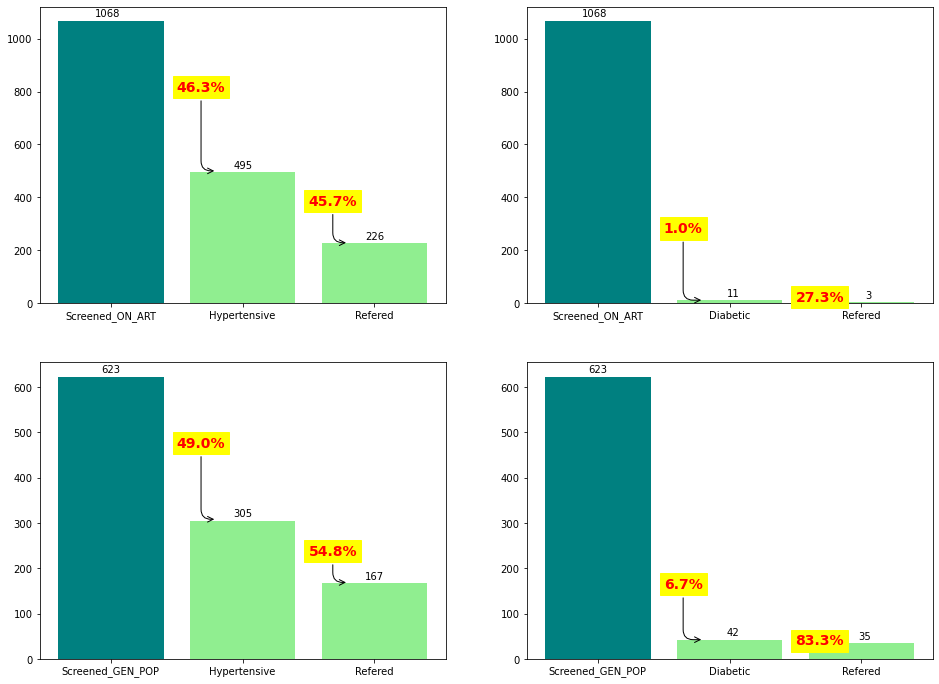

In [31]:
ncd_grid(byo_hptn_cascade_art, byo_dm_cascade_art, byo_hptn_cascade_gen, byo_dm_cascade_gen)

## Chitungwiza

In [32]:
# Monthly Targets
target_chit = monthly_target("Chitungwiza", df, last_date_prev_month, 3)
last_month_chit, ncd_chit, referred_chit, perc_screened_chit, perc_ncd_chit, perc_refered_chit = cascade_indicators_monthly(chitungwiza, target_chit)

### Chitungwiza Overall Cascade

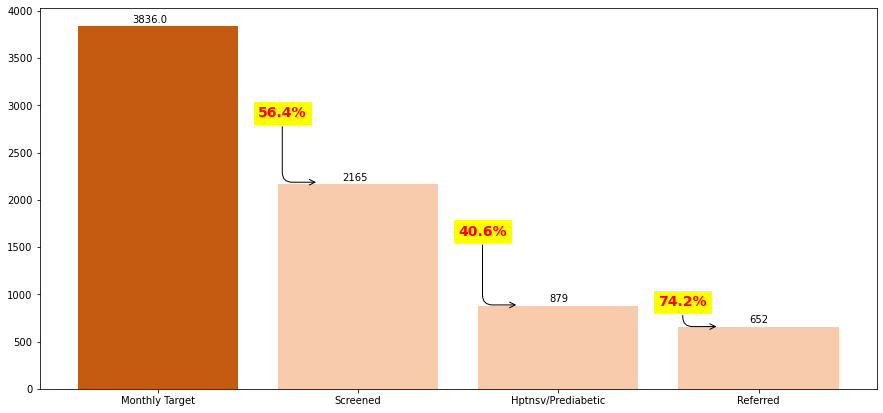

In [33]:
monthly_cascade(target_chit, last_month_chit, ncd_chit, referred_chit, perc_screened_chit, perc_ncd_chit, perc_refered_chit)

### Distibution Gen Pop: On ART (Chitungwiza)

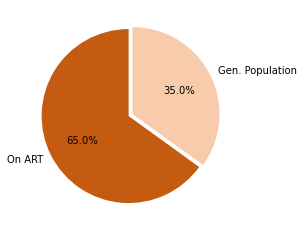

In [34]:
on_art_chit, gen_pop_chit = art_genpop(chitungwiza)
fig, ax = plt.subplots()
ax.pie(x = [len(on_art_chit), len(gen_pop_chit)], labels=["On ART", "Gen. Population"], 
       startangle=90, explode=[0.025, 0.025], colors=["#C55A11","#F8CBAD"], autopct='%1.1f%%')
plt.show()

### PLHIV vs GEN. POP Cascades - Chitungwiza

In [35]:
on_art_chit_df, on_art_chit_screened = screened_period(on_art_chit, last_date_reporting_month, first_date=first_date_reporting_month)
on_art_chit_dm, on_art_chit_hptn, on_art_chit_referred = ncd_pos(on_art_chit_df)

gen_pop_chit_df, gen_pop_chit_screened = screened_period(gen_pop_chit, last_date_reporting_month, first_date=first_date_reporting_month)
gen_pop_chit_dm, gen_pop_chit_hptn, gen_pop_chit_referred = ncd_pos(gen_pop_chit_df)

In [36]:
# inputs into ncd_grid:

chit_hptn_cascade_art = [on_art_chit_screened, len(on_art_chit_hptn), len(referrals_per_ncd(on_art_chit_hptn))]
chit_dm_cascade_art = [on_art_chit_screened, len(on_art_chit_dm), len(referrals_per_ncd(on_art_chit_dm))]

chit_hptn_cascade_gen = [gen_pop_chit_screened, len(gen_pop_chit_hptn), len(referrals_per_ncd(gen_pop_chit_hptn))]
chit_dm_cascade_gen = [gen_pop_chit_screened, len(gen_pop_chit_dm), len(referrals_per_ncd(gen_pop_chit_dm))]

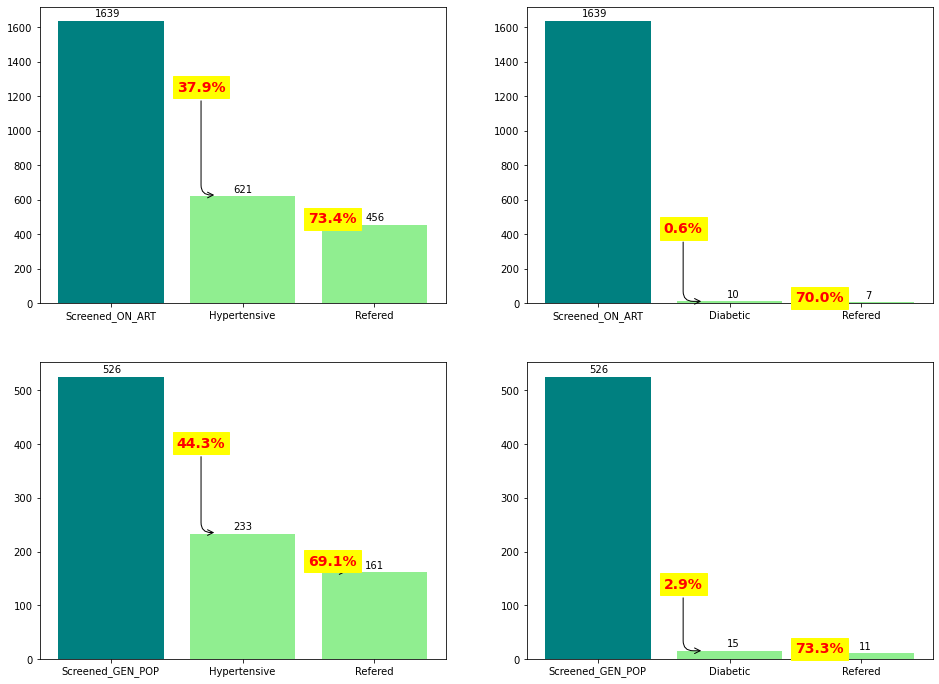

In [37]:
ncd_grid(chit_hptn_cascade_art, chit_dm_cascade_art, chit_hptn_cascade_gen, chit_dm_cascade_gen)

### Cumulative Analysis by PLHIV vs. Gen Pop

In [38]:
screened_df, cumulative_screened = screened_period(df, last_date_reporting_month)
diabetic, hypertensive, referred = ncd_pos(df)
prev_hypertension = len(df[df['CTL - NCD Have you previously been diagnosed with BP']==1.0])
prev_diabetes = len(df[df['CTL - NCD Have you been previously diagnosed with Diabetes Mellitus']==1.0])


plhiv_total, gen_pop_total = art_genpop(df)
prev_hptn_plhiv = len(plhiv_total[plhiv_total['CTL - NCD Have you previously been diagnosed with BP']==1.0])
prev_hptn_gen = len(gen_pop_total[gen_pop_total['CTL - NCD Have you previously been diagnosed with BP']==1.0])
prev_dm_plhiv = len(plhiv_total[plhiv_total['CTL - NCD Have you been previously diagnosed with Diabetes Mellitus']==1.0])
prev_dm_gen = len(gen_pop_total[gen_pop_total['CTL - NCD Have you been previously diagnosed with Diabetes Mellitus']==1.0])

In [39]:
screened_dm = len(screened_df[screened_df['CTL - NCD Random blood sugar']>0.0])
screened_hptn = len(screened_df[(screened_df['CTL - NCD Systolic blood pressure']>70)|(screened_df['CTL - NCD Diastolic blood pressure']>40)])

screened_dm_plhiv = len(plhiv_total[plhiv_total['CTL - NCD Random blood sugar']>0.0])
screened_dm_gen = len(gen_pop_total[gen_pop_total['CTL - NCD Random blood sugar']>0.0])
screened_hptn_plhiv = len(plhiv_total[(plhiv_total['CTL - NCD Systolic blood pressure']>70)|(plhiv_total['CTL - NCD Diastolic blood pressure']>40)])
screened_hptn_gen = len(gen_pop_total[(gen_pop_total['CTL - NCD Systolic blood pressure']>70)|(gen_pop_total['CTL - NCD Diastolic blood pressure']>40)])

diabetic_plhiv, hypertensive_plhiv, referred_plhiv = ncd_pos(plhiv_total)
diabetic_gen, hypertensive_gen, referred_gen = ncd_pos(gen_pop_total)

In [40]:
table_data = [["Variable", "Total n(%)", "PLHIV n(%)", "Gen. Pop. n(%)"],
              ["Total Screened to Date", cumulative_screened, len(plhiv_total), len(gen_pop_total)], 
              ["No. Previously diagnosed with Diabetes Mellitus",prev_diabetes,prev_dm_plhiv ,prev_dm_gen],
              ["Screened for Diabetes Mellitus",screened_dm , screened_dm_plhiv, screened_dm_gen],
              ["Diabetic", len(diabetic), len(diabetic_plhiv), len(diabetic_gen)],
              ["No. Previously diagnosed with Hypertension", prev_hypertension, prev_hptn_plhiv, prev_hptn_gen], 
              ["Screened for hypertension",screened_hptn , screened_hptn_plhiv, screened_hptn_gen],
              ["Hypertensive",len(hypertensive) ,len(hypertensive_plhiv), len(hypertensive_gen)]]

print(tabulate(table_data, headers="firstrow"))

Variable                                           Total n(%)    PLHIV n(%)    Gen. Pop. n(%)
-----------------------------------------------  ------------  ------------  ----------------
Total Screened to Date                                   8932          5833              3080
No. Previously diagnosed with Diabetes Mellitus           344           129               212
Screened for Diabetes Mellitus                           3349          2140              1208
Diabetic                                                  194            76               117
No. Previously diagnosed with Hypertension               1501           728               768
Screened for hypertension                                7895          5000              2896
Hypertensive                                             3831          2437              1393


### Cumulative Analysis by Gender - Table

In [41]:
male_total, female_total = male_female(df)

prev_hptn_male = len(male_total[male_total['CTL - NCD Have you previously been diagnosed with BP']==1.0])
prev_hptn_female = len(female_total[female_total['CTL - NCD Have you previously been diagnosed with BP']==1.0])
prev_dm_male = len(male_total[male_total['CTL - NCD Have you been previously diagnosed with Diabetes Mellitus']==1.0])
prev_dm_female = len(female_total[female_total['CTL - NCD Have you been previously diagnosed with Diabetes Mellitus']==1.0])

screened_dm_male = len(male_total[male_total['CTL - NCD Random blood sugar']>0.0])
screened_dm_female = len(female_total[female_total['CTL - NCD Random blood sugar']>0.0])
screened_hptn_male = len(male_total[(male_total['CTL - NCD Systolic blood pressure']>70)|(male_total['CTL - NCD Diastolic blood pressure']>40)])
screened_hptn_female = len(female_total[(female_total['CTL - NCD Systolic blood pressure']>70)|(female_total['CTL - NCD Diastolic blood pressure']>40)])

diabetic_male, hypertensive_male, referred_male = ncd_pos(male_total)
diabetic_female, hypertensive_female, referred_female = ncd_pos(female_total)

In [42]:
table_data = [["Variable", "Total n(%)", "Male n(%)", "Female n(%)"],
              ["Total Screened to Date", cumulative_screened, len(male_total), len(female_total)], 
              ["No. Previously diagnosed with Diabetes Mellitus",prev_diabetes,prev_dm_male ,prev_dm_female],
              ["Screened for Diabetes Mellitus",screened_dm , screened_dm_male, screened_dm_female],
              ["Diabetic", len(diabetic), len(diabetic_male), len(diabetic_female)],
              ["No. Previously diagnosed with Hypertension", prev_hypertension, prev_hptn_male, prev_hptn_female], 
              ["Screened for hypertension",screened_hptn , screened_hptn_male, screened_hptn_female],
              ["Hypertensive",len(hypertensive), len(hypertensive_male), len(hypertensive_female)]]

print(tabulate(table_data, headers="firstrow"))

Variable                                           Total n(%)    Male n(%)    Female n(%)
-----------------------------------------------  ------------  -----------  -------------
Total Screened to Date                                   8932         3127           5851
No. Previously diagnosed with Diabetes Mellitus           344          122            222
Screened for Diabetes Mellitus                           3349         1220           2129
Diabetic                                                  194           61            133
No. Previously diagnosed with Hypertension               1501          403           1098
Screened for hypertension                                7895         2701           5196
Hypertensive                                             3831         1276           2555


### Monthly Totals

In [43]:
# cumulative, month by month

<h1 style="color:red"> ANOMALOUS READINGS</h1>

<p>This section will identify any entries that are anomalous by COA/Health Worker to gain a better understanding of the
    screening and reporting process</p>

In [44]:
screened_reporting_df, number_screened = screened_period(df, last_date_reporting_month, first_date = first_date_reporting_month)

#### screening under 30s

In [45]:
less_than_40 = screened_reporting_df[screened_reporting_df['Age'] < 30]

In [48]:
from pivottablejs import pivot_ui

In [53]:
from IPython.display import HTML

pivot_ui(less_than_40)
